## Importing the requried libraries

In [7]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

## Setting up the image directories

In [8]:
hdf5_file = r"C:\Users\vudut\OneDrive\Desktop\Python\MINI Project\Data Sets\jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5"  # Change to your actual file
output_dir = "higgs_images"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

In [17]:
for path in [train_dir, val_dir]:
    os.makedirs(os.path.join(path, "signal"), exist_ok=True)
    os.makedirs(os.path.join(path, "background"), exist_ok=True)


## Loading the dataset

In [18]:
with h5py.File(hdf5_file, "r") as f:
    print(list(f.keys()))  # Lists all available keys

['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']


In [19]:
with h5py.File(hdf5_file, "r") as f:
    features = np.array(f["image"])  # Corrected key
    labels = np.array(f["signal"])  # Corrected key

In [20]:
# Ensure image dimensions are valid
num_samples, img_height, img_width = features.shape
assert img_height == img_width, "Images must be square"


## Saving the images

In [21]:
# Save images
train_split = int(0.8 * num_samples)
for i in tqdm(range(num_samples), desc="Saving images"):
    img = features[i]
    label = "signal" if labels[i] == 1 else "background"
    
    folder = train_dir if i < train_split else val_dir
    filename = os.path.join(folder, label, f"{i}.png")
    
    plt.imsave(filename, img, cmap="gray")  # Save as grayscale image

print("✅ Conversion complete! Images saved in:", output_dir)

Saving images: 100%|██████████| 872666/872666 [35:41<00:00, 407.48it/s]   


✅ Conversion complete! Images saved in: higgs_images


## Visualing the images

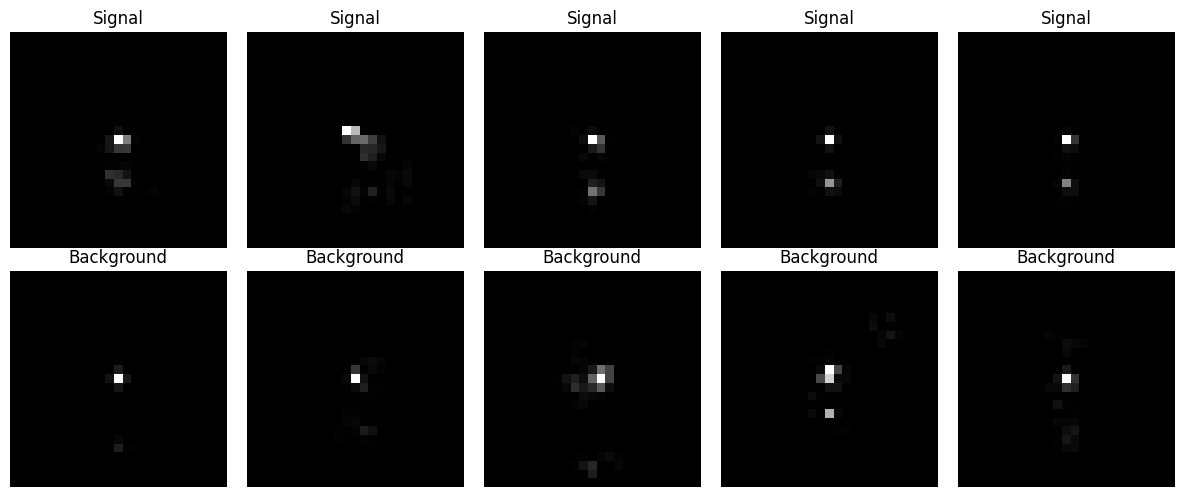

In [4]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Define paths
train_signal_dir = "higgs_images/train/signal"
train_background_dir = "higgs_images/train/background"

# Select random images from each category
signal_images = random.sample(os.listdir(train_signal_dir), 5)
background_images = random.sample(os.listdir(train_background_dir), 5)

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, img_name in enumerate(signal_images):
    img_path = os.path.join(train_signal_dir, img_name)
    img = Image.open(img_path)
    axes[0, i].imshow(img, cmap="gray")
    axes[0, i].set_title("Signal")
    axes[0, i].axis("off")

for i, img_name in enumerate(background_images):
    img_path = os.path.join(train_background_dir, img_name)
    img = Image.open(img_path)
    axes[1, i].imshow(img, cmap="gray")
    axes[1, i].set_title("Background")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

## Loading the dataset

In [13]:
import tensorflow as tf

# Dataset Paths
train_dir = "higgs_images/train"
val_dir = "higgs_images/val"
batch_size = 4  # Reduce batch size to prevent kernel crashes
img_size = (32, 32)  # Match generated image size

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",  # Binary classification (signal vs background)
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary"
)

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("✅ Dataset loaded successfully!")


Found 698132 files belonging to 2 classes.
Found 174534 files belonging to 2 classes.
✅ Dataset loaded successfully!


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
import wandb

In [15]:
# ✅ Initialize Weights & Biases (W&B)
wandb.init(project="higgs_boson_cnn", name="project_cnn1")

# ✅ Define CNN Architecture
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")  # Binary classification
    ])
    return model

# ✅ Create and Compile Model
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [17]:
# ✅ Train Model
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10
    )

# ✅ Evaluate Model
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")


Epoch 1/10
174533/174533 [==============================] - 1058s 6ms/step - loss: 0.4495 - accuracy: 0.7972 - val_loss: 0.4269 - val_accuracy: 0.8135
Epoch 2/10
174533/174533 [==============================] - 1009s 6ms/step - loss: 0.4267 - accuracy: 0.8103 - val_loss: 0.4167 - val_accuracy: 0.8162
Epoch 3/10
174533/174533 [==============================] - 1018s 6ms/step - loss: 0.4221 - accuracy: 0.8131 - val_loss: 0.4127 - val_accuracy: 0.8177
Epoch 4/10
174533/174533 [==============================] - 1117s 6ms/step - loss: 0.4204 - accuracy: 0.8137 - val_loss: 0.4130 - val_accuracy: 0.8175
Epoch 5/10
174533/174533 [==============================] - 1036s 6ms/step - loss: 0.4199 - accuracy: 0.8140 - val_loss: 0.4152 - val_accuracy: 0.8179
Epoch 6/10
174533/174533 [==============================] - 1390s 8ms/step - loss: 0.4191 - accuracy: 0.8148 - val_loss: 0.4138 - val_accuracy: 0.8175
Epoch 7/10
174533/174533 [==============================] - 1424s 8ms/step - loss: 0.4191 - ac

In [18]:
model.save("particle_cnn_model.h5")

In [19]:
new_model = tf.keras.models.load_model("particle_cnn_model.h5")
print("✅ Model loaded successfully!")

✅ Model loaded successfully!
